# Define and train model

In [1]:
import os
import sys
import time
import numpy as np
import torch
import random
import wandb
from datetime import datetime
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

sys.path.append(os.getcwd())
from torch.utils.data import DataLoader
from data.dataloader_dance import DanceDataset, seq_collate
from model.GroupNet_dance import GroupNet
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(0)

In [3]:
class Args:
    def __init__(self):
        # Training parameters
        self.seed = 1
        self.dataset = 'dance'
        self.wandb_enabled = True  # Set to True to enable WandB logging
        self.wandb_project = 'GroupNet'  # WandB project name
        self.batch_size = 64 # batch size
        self.past_length = 8 # number of frames to condition on
        self.future_length = 11 # number of frames to predict into the future 
        self.traj_scale = 1 # scale factor applied to trajectory coordinates
        self.learn_prior = False # whether to learn prior distribution vs using fixed prior
        self.lr = 3e-4 # learning rate
        self.weight_decay = 0.0001
        self.sample_k = 20 # number of samples to generate during testing for diverse predictions
        self.num_epochs = 5 # MAKE 100
        self.decay_step = 10 # number of epochs before applying learning rate decay
        self.decay_gamma = 0.9 # learning rate decay factor
        self.print_every_it = 18 # print training stats every N iterations
        # self.test_every_it = 27 # test model every N iterations

        # Model parameters
        self.ztype = 'gaussian' # type of latent distribution: 'gaussian' or 'vmf'
        self.zdim = 32 # dimension of latent variable
        self.hidden_dim = 64 # dimension of hidden layers
        self.hyper_scales = [15,53] # scales for hyperprior ([5,11] for nba)
        self.edge_types = 3 # number of diff hyperedges to detect for each scale
        self.num_decompose = 2 # number of decomposed distributions
        self.min_clip = 2.0

        # Save/load parameters
        self.model_save_dir = 'saved_models/dance'
        self.model_save_epoch = 5 # save model every N epochs
        self.epoch_continue = 0 # epoch to continue training from, 0 if training from scratch
    
    def __str__(self):
        return str(self.__dict__)

args = Args()

In [4]:
datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
datetime_str

'2025-05-02_18-49-29'

In [5]:
""" setup """
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.set_default_dtype(torch.float32)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:',device)
print(args)

# Initialize WandB
if args.wandb_enabled:
	wandb.init(project=args.wandb_project,config=args.__dict__)

if not os.path.isdir(args.model_save_dir):
    os.makedirs(args.model_save_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


device: cuda
{'seed': 1, 'dataset': 'dance', 'wandb_enabled': True, 'wandb_project': 'GroupNet', 'batch_size': 64, 'past_length': 8, 'future_length': 11, 'traj_scale': 1, 'learn_prior': False, 'lr': 0.0003, 'weight_decay': 0.0001, 'sample_k': 20, 'num_epochs': 5, 'decay_step': 10, 'decay_gamma': 0.9, 'print_every_it': 18, 'ztype': 'gaussian', 'zdim': 32, 'hidden_dim': 64, 'hyper_scales': [15, 53], 'edge_types': 3, 'num_decompose': 2, 'min_clip': 2.0, 'model_save_dir': 'saved_models/dance', 'model_save_epoch': 5, 'epoch_continue': 0}


wandb: Currently logged in as: vikhyat3 (university-of-richmond). Use `wandb login --relogin` to force relogin


In [6]:
foo = np.load('datasets/dance/train.npy') 
foo.shape

(1612, 19, 53, 6)

In [7]:
""" model & optimizer """
model = GroupNet(args,device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=args.decay_step, gamma=args.decay_gamma)

train_size = 20

""" dataloader """
train_set = DanceDataset(
    obs_len=args.past_length,
    pred_len=args.future_length,
    n_samples=train_size,
    training=True)

train_loader = DataLoader(
    train_set,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=seq_collate,
    pin_memory=True)

test_set = DanceDataset(
    obs_len=args.past_length,
    pred_len=args.future_length,
    n_samples=5,
    training=False)

test_loader = DataLoader(
    test_set,
    batch_size=len(test_set),
    shuffle=True,
    num_workers=4,
    collate_fn=seq_collate,
    pin_memory=True)

Loaded Train data with shape: (20, 19, 53, 3)
20
Loaded Test data with shape: (5, 19, 53, 3)
5


In [8]:
""" Loading if needed """
if args.epoch_continue > 0:
    checkpoint_path = os.path.join(args.model_save_dir,str(args.epoch_continue)+'.p')
    print('load model from: {checkpoint_path}')
    model_load = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(model_load['model_dict'])
    if 'optimizer' in model_load:
        optimizer.load_state_dict(model_load['optimizer'])
    if 'scheduler' in model_load:
        scheduler.load_state_dict(model_load['scheduler'])

In [9]:
# show all parameter shapes for GroupNet, and count total number of parameters
total_params = 0
for name, param in model.named_parameters():
	print(name, param.data.shape)
	total_params += np.prod(param.data.shape)
print('Total number of parameters:', total_params)

past_encoder.input_fc.weight torch.Size([64, 6])
past_encoder.input_fc.bias torch.Size([64])
past_encoder.input_fc2.weight torch.Size([64, 512])
past_encoder.input_fc2.bias torch.Size([64])
past_encoder.interaction.nmp_mlp_start.MLP_distribution.layers.0.weight torch.Size([128, 64])
past_encoder.interaction.nmp_mlp_start.MLP_distribution.layers.0.bias torch.Size([128])
past_encoder.interaction.nmp_mlp_start.MLP_distribution.layers.1.weight torch.Size([3, 128])
past_encoder.interaction.nmp_mlp_start.MLP_distribution.layers.1.bias torch.Size([3])
past_encoder.interaction.nmp_mlp_start.MLP_factor.layers.0.weight torch.Size([128, 64])
past_encoder.interaction.nmp_mlp_start.MLP_factor.layers.0.bias torch.Size([128])
past_encoder.interaction.nmp_mlp_start.MLP_factor.layers.1.weight torch.Size([1, 128])
past_encoder.interaction.nmp_mlp_start.MLP_factor.layers.1.bias torch.Size([1])
past_encoder.interaction.nmp_mlp_start.init_MLP.layers.0.weight torch.Size([128, 64])
past_encoder.interaction.n

In [10]:
args.num_epochs = 1

In [11]:
""" start training """
model.set_device(device)
for epoch in range(args.epoch_continue, args.num_epochs):
    model.train()
    total_iter_num = len(train_loader)
    iter_num = 0
    epoch_start_time = time.time()
    epoch_loss = 0

    for data in train_loader:
        total_loss, loss_pred, loss_recover, loss_kl, loss_diverse = model(data)
        epoch_loss += total_loss.item()

        """ optimize """
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if iter_num % args.print_every_it == 0:
            print('Epochs: {:02d}/{:02d}| It: {:04d}/{:04d} | Train loss: {:6.3f} (pred: {:6.3f}| recover: {:6.3f}| kl: {:6.3f}| diverse: {:6.3f})'
                    .format(epoch,args.num_epochs,iter_num,total_iter_num,total_loss.item(),loss_pred,loss_recover,loss_kl,loss_diverse))
            # Log metrics to WandB if enabled
            if args.wandb_enabled:
                wandb.log({
                    'train_loss': total_loss.item(),
                    'pred_loss': loss_pred,
                    'recover_loss': loss_recover,
                    'kl_loss': loss_kl,
                    'diverse_loss': loss_diverse,
                    'epoch': epoch,
                    'iteration': iter_num
                })

        iter_num += 1

    epoch_time = time.time() - epoch_start_time
    avg_loss = epoch_loss / total_iter_num
    print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds. Average loss: {avg_loss:.3f}')
    
    scheduler.step()
    model.step_annealer()
    
    """ save model """
    if  (epoch + 1) % args.model_save_epoch == 0:
        model_saved = {'model_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'epoch': epoch + 1,'model_cfg': args}
        saved_path = os.path.join(args.model_save_dir,str(epoch+1)+'.p')
        torch.save(model_saved, saved_path)

/home/va6hp/GroupNet/model/MS_HGNN_batch.py:478: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)


Epochs: 00/01| It: 0000/0001 | Train loss: 22.625 (pred:  1.533| recover: 18.828| kl:  2.000| diverse:  0.264)
Epoch 0 completed in 0.54 seconds. Average loss: 22.625


In [12]:
args.model_save_dir

'saved_models/dance'

In [13]:
# # Load model
# saved_path = os.path.join(args.model_save_dir,str(20)+'.p')
# model_load = torch.load(saved_path, map_location=device)
# model.load_state_dict(model_load['model_dict'])
# model.to(device)

In [14]:
# Define time steps for evaluation (in seconds)
time_steps = [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0]  # 10 time steps
num_steps = len(time_steps)

# Initialize arrays for error metrics
all_num = 0
l2error_avg = np.zeros(num_steps)  # Average error at each time step
l2error_dest = np.zeros(num_steps)  # Final position error at each time step

for data in test_loader:
	future_traj = np.array(data['future_traj']) * args.traj_scale # B,N,T,2
	with torch.no_grad():
		prediction = model.inference(data)
	prediction = prediction * args.traj_scale
	prediction = np.array(prediction.cpu()) #(BN,20,T,2)
	batch = future_traj.shape[0]
	actor_num = future_traj.shape[1]

	y = np.reshape(future_traj,(batch*actor_num,args.future_length, 3))
	y = np.repeat(y[np.newaxis, :, :, :], 20, axis=0)  # Add a dimension and repeat
	
	# Calculate errors for each time step
	for i in range(num_steps):
		frames_up_to_i = min(i+1, args.future_length)  # Use up to i+1 frames or max available
		# Average error across all frames up to this time step
		l2error_avg[i] += np.mean(np.min(np.mean(np.linalg.norm(
			y[:,:,:frames_up_to_i,:] - prediction[:,:,:frames_up_to_i,:], axis=3), axis=2), axis=0)) * batch
		# Final position error at this time step (if available)
		if i < args.future_length:
			l2error_dest[i] += np.mean(np.min(np.mean(np.linalg.norm(
				y[:,:,i:i+1,:] - prediction[:,:,i:i+1,:], axis=3), axis=2), axis=0)) * batch
	
	all_num += batch

# Normalize errors by total number of samples
l2error_avg /= all_num
l2error_dest /= all_num

print('##################')
print(f'Number of test samples: {all_num}')
print('\nError metrics at different time horizons:')
for i, t in enumerate(time_steps):
    print(f'Time {t:.1f}s - ADE: {l2error_avg[i]:.4f}, FDE: {l2error_dest[i]:.4f}')

# Print specific intervals for comparison with other papers
print('\nSummary metrics:')
print(f'ADE 1.0s: {(l2error_avg[1] + l2error_avg[2])/2:.4f}')  # ~0.8s + 1.2s
print(f'ADE 2.0s: {l2error_avg[4]:.4f}')  # 2.0s
print(f'ADE 3.0s: {(l2error_avg[6] + l2error_avg[7])/2:.4f}')  # ~2.8s + 3.2s
print(f'ADE 4.0s: {l2error_avg[-1]:.4f}')  # 4.0s (last time step)
print()
print(f'FDE 1.0s: {(l2error_dest[1] + l2error_dest[2])/2:.4f}')
print(f'FDE 2.0s: {l2error_dest[4]:.4f}')
print(f'FDE 3.0s: {(l2error_dest[6] + l2error_dest[7])/2:.4f}')
print(f'FDE 4.0s: {l2error_dest[-1]:.4f}')
print('##################')

##################
Number of test samples: 5

Error metrics at different time horizons:
Time 0.4s - ADE: 0.0306, FDE: 0.0306
Time 0.8s - ADE: 0.0359, FDE: 0.0200
Time 1.2s - ADE: 0.0400, FDE: 0.0231
Time 1.6s - ADE: 0.0455, FDE: 0.0295
Time 2.0s - ADE: 0.0496, FDE: 0.0345
Time 2.4s - ADE: 0.0519, FDE: 0.0342
Time 2.8s - ADE: 0.0560, FDE: 0.0471
Time 3.2s - ADE: 0.0622, FDE: 0.0674
Time 3.6s - ADE: 0.0640, FDE: 0.0464
Time 4.0s - ADE: 0.0684, FDE: 0.0703

Summary metrics:
ADE 1.0s: 0.0379
ADE 2.0s: 0.0496
ADE 3.0s: 0.0591
ADE 4.0s: 0.0684

FDE 1.0s: 0.0216
FDE 2.0s: 0.0345
FDE 3.0s: 0.0572
FDE 4.0s: 0.0703
##################


# Last Frame Baseline
Test a simple baseline that uses the last observed frame as the prediction for all future frames

In [15]:
# Calculate baseline prediction error
all_num = 0
baseline_avg_error = np.zeros(num_steps)  # Average error at each time step
baseline_dest_error = np.zeros(num_steps)  # Final position error at each time step

for data in test_loader:
    past_traj = data['past_traj']  # B,N,T,3  
    future_traj = data['future_traj']  # B,N,T,3
    
    # Use last frame of past trajectory as prediction
    last_frame = past_traj[:,:,-1:,:]  # B,N,1,3
    prediction = last_frame.repeat(1, 1, args.future_length, 1)  # B,N,T,3
    
    batch = future_traj.shape[0]
    actor_num = future_traj.shape[1]
    
    # Convert to numpy for consistent evaluation
    future_traj_np = future_traj.cpu().numpy()
    prediction_np = prediction.cpu().numpy()
    
    # Reshape data for evaluation
    y = np.reshape(future_traj_np, (batch*actor_num, args.future_length, 3))
    pred = np.reshape(prediction_np, (batch*actor_num, args.future_length, 3))
    
    # We only need one copy since baseline is deterministic (no sampling)
    y_expanded = np.expand_dims(y, axis=0)  # Add a dimension to match format of previous evaluation
    pred_expanded = np.expand_dims(pred, axis=0)
    
    # Calculate errors for each time step
    for i in range(num_steps):
        frames_up_to_i = min(i+1, args.future_length)  # Use up to i+1 frames or max available
        # Average error across all frames up to this time step
        baseline_avg_error[i] += np.mean(np.linalg.norm(
            y_expanded[:,:,:frames_up_to_i,:] - pred_expanded[:,:,:frames_up_to_i,:], axis=3).mean(axis=2)) * batch
        # Final position error at this time step (if available)
        if i < args.future_length:
            baseline_dest_error[i] += np.mean(np.linalg.norm(
                y_expanded[:,:,i:i+1,:] - pred_expanded[:,:,i:i+1,:], axis=3).mean(axis=2)) * batch
    
    all_num += batch

# Normalize errors by total number of samples
baseline_avg_error /= all_num
baseline_dest_error /= all_num

print('##################')
print('Baseline Results:')
print(f'Number of test samples: {all_num}')
print('\nError metrics at different time horizons:')
for i, t in enumerate(time_steps):
    print(f'Time {t:.1f}s - ADE: {baseline_avg_error[i]:.4f}, FDE: {baseline_dest_error[i]:.4f}')

# Print specific intervals for comparison with other papers
print('\nSummary metrics:')
print(f'ADE 1.0s: {(baseline_avg_error[1] + baseline_avg_error[2])/2:.4f}')  # ~0.8s + 1.2s
print(f'ADE 2.0s: {baseline_avg_error[4]:.4f}')  # 2.0s
print(f'ADE 3.0s: {(baseline_avg_error[6] + baseline_avg_error[7])/2:.4f}')  # ~2.8s + 3.2s
print(f'ADE 4.0s: {baseline_avg_error[-1]:.4f}')  # 4.0s (last time step)
print()
print(f'FDE 1.0s: {(baseline_dest_error[1] + baseline_dest_error[2])/2:.4f}')
print(f'FDE 2.0s: {baseline_dest_error[4]:.4f}')
print(f'FDE 3.0s: {(baseline_dest_error[6] + baseline_dest_error[7])/2:.4f}')
print(f'FDE 4.0s: {baseline_dest_error[-1]:.4f}')
print('##################')

##################
Baseline Results:
Number of test samples: 5

Error metrics at different time horizons:
Time 0.4s - ADE: 0.0104, FDE: 0.0104
Time 0.8s - ADE: 0.0151, FDE: 0.0199
Time 1.2s - ADE: 0.0197, FDE: 0.0288
Time 1.6s - ADE: 0.0240, FDE: 0.0370
Time 2.0s - ADE: 0.0281, FDE: 0.0443
Time 2.4s - ADE: 0.0318, FDE: 0.0508
Time 2.8s - ADE: 0.0354, FDE: 0.0569
Time 3.2s - ADE: 0.0388, FDE: 0.0627
Time 3.6s - ADE: 0.0421, FDE: 0.0686
Time 4.0s - ADE: 0.0454, FDE: 0.0750

Summary metrics:
ADE 1.0s: 0.0174
ADE 2.0s: 0.0281
ADE 3.0s: 0.0371
ADE 4.0s: 0.0454

FDE 1.0s: 0.0243
FDE 2.0s: 0.0443
FDE 3.0s: 0.0598
FDE 4.0s: 0.0750
##################


# Visualize Hyperedge Groupings

We'll extract and visualize how the model groups the 53 joints into hyperedges at different scales.

In [16]:
# Fetch one batch from the test loader for visualization
for i in train_loader:
    sample_batch = i
    break

In [17]:
sample_batch['past_traj'].shape, sample_batch['future_traj'].shape

(torch.Size([20, 53, 8, 3]), torch.Size([20, 53, 11, 3]))

In [18]:
def get_sample_frame(batch, sample_i, frame_i):
	# Get the sample trajectory for the given batch and frame index
	return batch['past_traj'][sample_i, :, frame_i, :].cpu().numpy()

In [19]:
def extract_hypergraph(model, sample_batch):
    """
    Extract hypergraph structure from a trained GroupNet model
    Args:
        model: trained GroupNet model
        sample_batch: single batch of data containing past trajectories
    Returns:
        List of hyperedge groupings at each scale. Each element in the list is a tensor of shape
        (batch_size, num_joints, num_hyperedges) where:
        - batch_size: Number of samples in the batch
        - num_joints: Number of joints in the skeleton (53 for dance dataset)
        - num_hyperedges: Number of hyperedges at this scale, equal to the value in model.args.hyper_scales
        
        This shape reflects how each joint is assigned membership probabilities across multiple
        hyperedges, allowing the model to capture different levels of grouping at each scale.
    """
    # Set model to eval mode
    model.eval()

    # Get past trajectories from data sample
    past_traj = sample_batch['past_traj'].to(model.device)
    past_vel = past_traj[:, :, 1:] - past_traj[:, :, :-1]
    past_vel = torch.cat([past_vel[:, :, [0]], past_vel], dim=2)
    inputs = torch.cat((past_traj, past_vel), dim=-1)

    # Get batch info
    batch_size = past_traj.shape[0]
    agent_num = past_traj.shape[1]

    # Forward pass through initial layers
    length = inputs.shape[2]
    tf_in = model.past_encoder.input_fc(inputs.view(batch_size*agent_num, length, -1)).view(batch_size*agent_num, -1, model.past_encoder.model_dim)
    tf_in_pos = model.past_encoder.pos_encoder(tf_in, num_a=batch_size*agent_num)
    tf_in_pos = tf_in_pos.view(batch_size, agent_num, -1, model.past_encoder.model_dim)
    ftraj_input = model.past_encoder.input_fc2(tf_in_pos.contiguous().view(batch_size, -1, length*model.past_encoder.model_dim))

    # Get correlation matrix
    query_input = F.normalize(ftraj_input, p=2, dim=2)
    feat_corr = torch.matmul(query_input, query_input.permute(0, 2, 1))

    hypergraph_scales = []

    # Extract edge distributions from each hypergraph layer
    if len(model.args.hyper_scales) > 0:
        edge_dist = model.past_encoder.interaction_hyper.nmp_mlp_start.MLP_distribution(ftraj_input)
        edge_dist = F.softmax(edge_dist, dim=-1)
        hypergraph_scales.append(edge_dist)
        
    if len(model.args.hyper_scales) > 1:
        edge_dist = model.past_encoder.interaction_hyper2.nmp_mlp_start.MLP_distribution(ftraj_input) 
        edge_dist = F.softmax(edge_dist, dim=-1)
        hypergraph_scales.append(edge_dist)
        
    if len(model.args.hyper_scales) > 2:
        edge_dist = model.past_encoder.interaction_hyper3.nmp_mlp_start.MLP_distribution(ftraj_input)
        edge_dist = F.softmax(edge_dist, dim=-1)
        hypergraph_scales.append(edge_dist)
    
    return hypergraph_scales

def print_hypergraph(hypergraph_scales, threshold=0.1):
    """
    Print hyperedge assignments at each scale
    Args:
        hypergraph_scales: List of edge distribution tensors from extract_hypergraph,
                          each with shape (batch_size, num_joints, num_hyperedges)
        threshold: Minimum probability to consider a node part of a hyperedge
        
    The function prints out textual representation of hyperedge memberships,
    showing which joints belong to which hyperedges with probability above threshold.
    This helps interpret the learned groupings at different scales of the model.
    """
    try:
        from data.datahelper_dance import point_labels
    except ImportError:
        print("Could not import point_labels from data.datahelper_dance")
        point_labels = [f"Joint_{i}" for i in range(53)]  # Default labels if import fails
    
    print("Hypergraph Structure Analysis:")
    print("-" * 50)
    
    for scale_idx, edge_dist in enumerate(hypergraph_scales):
        print(f"\nScale {scale_idx + 1} (Scale factor: {model.args.hyper_scales[scale_idx]}):")
        print("-" * 30)
        
        # Get edge type assignments
        edge_types = edge_dist[0]  # Take first batch
        num_types = edge_types.shape[-1]
        
        for edge_type in range(num_types):
            # Get joints that belong to this hyperedge type
            member_joints = []
            for joint_idx in range(len(point_labels)):
                if edge_types[joint_idx, edge_type].item() > threshold:
                    member_joints.append((point_labels[joint_idx], 
                                       edge_types[joint_idx, edge_type].item()))
            
            if member_joints:
                print(f"\nHyperedge Type {edge_type}:")
                member_joints.sort(key=lambda x: x[1], reverse=True)
                for joint, prob in member_joints:
                    print(f"  {joint}: {prob:.3f}")

In [20]:
# Execute the hypergraph extraction and visualization
hypergraph_scales = extract_hypergraph(model, sample_batch)
print_hypergraph(hypergraph_scales)

Hypergraph Structure Analysis:
--------------------------------------------------

Scale 1 (Scale factor: 15):
------------------------------

Hyperedge Type 0:
  LHEL: 0.284
  LMT1: 0.284
  LTOE: 0.284
  LANK: 0.284
  LMT5: 0.284
  LKNI: 0.284
  LSHN: 0.284
  LKNE: 0.284
  RMT1: 0.284
  RTOE: 0.284
  RMT5: 0.284
  RIWR: 0.284
  RIHAND: 0.284
  ROHAND: 0.284
  RKNI: 0.284
  LTHI: 0.284
  ROWR: 0.284
  RANK: 0.284
  RKNE: 0.284
  RTHI: 0.284
  RSHN: 0.284
  MFWT: 0.284
  RHEL: 0.283
  RFRM: 0.283
  RFWT: 0.283
  LFWT: 0.283
  RIEL: 0.283
  STRN: 0.283
  RELB: 0.283
  RBWT: 0.283
  MBWT: 0.283
  LBWT: 0.283
  RUPA: 0.283
  CLAV: 0.283
  RFSH: 0.283
  LFSH: 0.283
  T10: 0.283
  LIEL: 0.282
  RBSH: 0.282
  LUPA: 0.282
  LBSH: 0.282
  C7: 0.282
  LELB: 0.282
  RBHD: 0.282
  LBHD: 0.282
  LFRM: 0.282
  LOWR: 0.282
  LIWR: 0.282
  LOHAND: 0.282
  RFHD: 0.282
  ARIEL: 0.282
  LIHAND: 0.282
  LFHD: 0.282

Hyperedge Type 1:
  LMT5: 0.358
  LTOE: 0.358
  LOHAND: 0.358
  LIHAND: 0.358
  LMT1: 0.35

In [21]:
for i in hypergraph_scales:
    print(i.shape)

torch.Size([20, 53, 3])
torch.Size([20, 53, 3])


In [22]:
# Function to visualize a dance pose with skeleton connections
def visualize_dance_skeleton(sample_batch, sample_frame, highlighted_joints=None):
	"""
	Visualize the dance pose skeleton with optional highlighting of specific joints
	
	Args:
		sample_batch: Sample from the dataset containing past_traj with shape (batch_size, num_joints, seq_len, 3)
		frame_idx: Frame index to visualize
		highlighted_joints: List of joint indices to highlight
	
	Returns:
		None - Displays a matplotlib plot showing the dance pose skeleton with optional highlighting.
		If highlighted_joints is provided, those joints will be colored red and
		displayed larger to emphasize them.
		
	The visualization shows the skeletal structure of the dance pose, with connections between
	related joints shown as lines. This helps interpret the hyperedge groupings by showing
	which physical parts of the skeleton are being grouped together by the model.
	"""
	# Try to import point labels and skeleton connections
	from data.datahelper_dance import point_labels, skeleton_lines
	
	# Extract joint positions from the data
	joints = sample_frame
	
	plt.figure(figsize=(10, 10))

	# Plot joints
	x = joints[:, 1]
	y = joints[:, 2]
	
	# Plot skeleton lines using skeleton_lines
	for edge in skeleton_lines:
		start_joint = edge[0][0]
		end_joint = edge[1][0]
		idx_start = point_labels.index(start_joint)
		idx_end = point_labels.index(end_joint)
		x_vals = [x[idx_start], x[idx_end]]
		y_vals = [y[idx_start], y[idx_end]]
		plt.plot(x_vals, y_vals, 'gray', alpha=0.7, linewidth=1)
	
	if highlighted_joints is None:
		# Plot all joints with same color
		plt.scatter(x, y, c='blue', s=30, alpha=0.8)
	else:
		# Create colors and sizes arrays for highlighting specific joints
		colors = ['red' if i in highlighted_joints else 'blue' for i in range(len(x))]
		sizes = [80 if i in highlighted_joints else 30 for i in range(len(x))]
		plt.scatter(x, y, c=colors, s=sizes, alpha=0.8)
	
	# Add labels for joints
	for i, (xi, yi, label) in enumerate(zip(x, y, point_labels)):
		if highlighted_joints is None or i in highlighted_joints:
			plt.annotate(label, (xi, yi), fontsize=8)
	
	plt.title(f"Dance Pose")
	plt.xlabel('X coordinate')
	plt.ylabel('Y coordinate')
	plt.grid(alpha=0.3)
	plt.axis('equal')
	plt.tight_layout()
	plt.show()

Highlighting most likely joints for Scale 15, Hyperedge 0


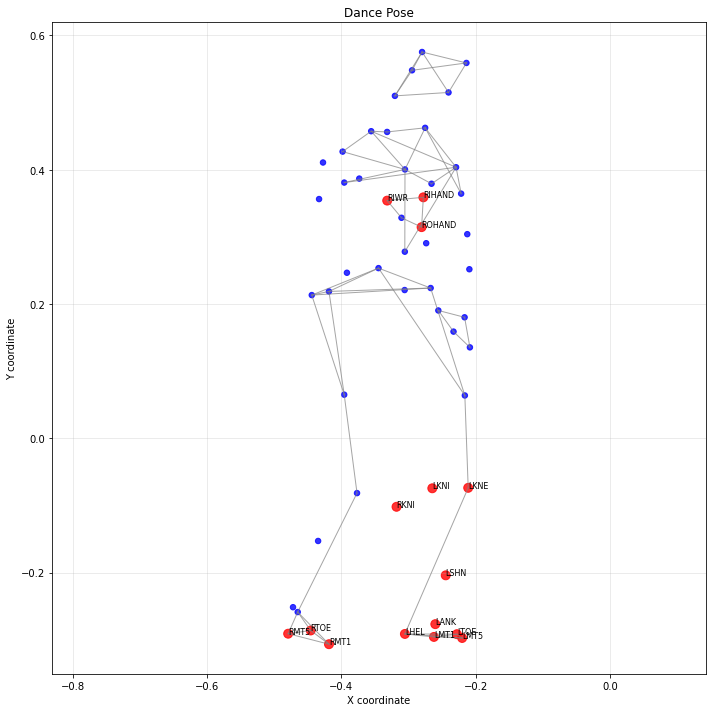

In [27]:
# Visualize a dance pose
sample_frame = get_sample_frame(sample_batch, 3, 0)

# visualize_dance_skeleton(sample_batch, sample_frame) # visualize the skeleton without highlighting

### Extract the top-k joints with highest probability for a specific hyperedge
### and highlight them in the skeleton visualization
scale_idx = 0
hyperedge_idx = 0
print(f"Highlighting most likely joints for Scale {model.args.hyper_scales[scale_idx]}, Hyperedge {hyperedge_idx}")

# Get hyperedge probabilities
edge_dist = hypergraph_scales[scale_idx][0]  # First batch
probs = edge_dist[:, hyperedge_idx].detach().cpu().numpy()

# Get indices of the top-k joints
k = model.args.hyper_scales[scale_idx]  # Size of hyperedge
top_k_indices = np.argsort(probs)[-k:]  # Get indices of top-k joints
highlighted_joints = top_k_indices.tolist()

visualize_dance_skeleton(sample_batch, sample_frame, highlighted_joints)